### 2x Better than Chance

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
import torch.nn.functional as F
from BcomMEG import *
from MEGDataset_Conv import *
from ConvNet import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# So one option would be to use ResNet as the pretrained and try to fine-tune it. 
# I'm not opposed to this, but it would require messing with the first layer, and
# making sort of arbitrary downscaling of the MEG data. We would have to be clever
# about this. I think I'm just going to try to train my own for right now and see
# how it goes
# resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# print(resnet.conv1)

In [2]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
dir1 = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
subjects = ['BCOM_18_2']
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [4]:
data.upscale(13)

In [5]:
dataset = MEGDataset_Conv(data, label_map='multi_class_covert')

In [22]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(
    list(range(len(dataset))), 
    test_size=0.4, 
    random_state=42, 
    stratify=dataset.labels)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch_index, (data, labels) in enumerate(train_loader):
    print(f"Batch {batch_index}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 0:
  Data shape: torch.Size([4, 1, 247, 241])
  Labels shape: torch.Size([4])


In [23]:
device = 'mps'
model = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

n_total_steps = len(train_loader)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader):
        labels = labels.to(device)
        # print(data)

        outputs = model(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        # print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')



Epoch [1 / 10], Step [10/31], Loss: 9.1708
Epoch [1 / 10], Step [20/31], Loss: 3.0337
Epoch [1 / 10], Step [30/31], Loss: 2.8899
Epoch [2 / 10], Step [10/31], Loss: 2.8610
Epoch [2 / 10], Step [20/31], Loss: 2.9205
Epoch [2 / 10], Step [30/31], Loss: 2.8394
Epoch [3 / 10], Step [10/31], Loss: 2.8073
Epoch [3 / 10], Step [20/31], Loss: 2.6034
Epoch [3 / 10], Step [30/31], Loss: 2.3858
Epoch [4 / 10], Step [10/31], Loss: 2.2282
Epoch [4 / 10], Step [20/31], Loss: 1.6561
Epoch [4 / 10], Step [30/31], Loss: 2.4278
Epoch [5 / 10], Step [10/31], Loss: 0.6494
Epoch [5 / 10], Step [20/31], Loss: 0.1801
Epoch [5 / 10], Step [30/31], Loss: 0.2328
Epoch [6 / 10], Step [10/31], Loss: 0.0791
Epoch [6 / 10], Step [20/31], Loss: 0.0413
Epoch [6 / 10], Step [30/31], Loss: 0.0056
Epoch [7 / 10], Step [10/31], Loss: 0.0166
Epoch [7 / 10], Step [20/31], Loss: 0.0376
Epoch [7 / 10], Step [30/31], Loss: 0.1085
Epoch [8 / 10], Step [10/31], Loss: 0.0259
Epoch [8 / 10], Step [20/31], Loss: 0.0929
Epoch [8 / 

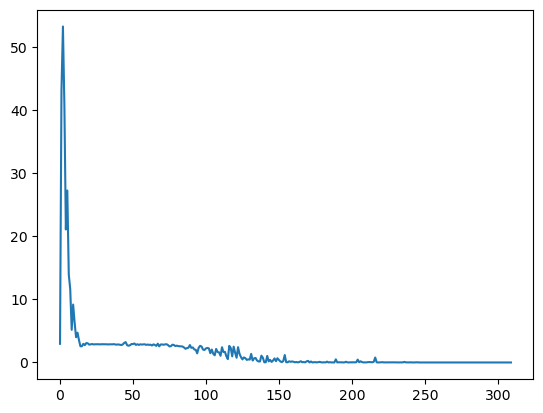

In [24]:
plt.plot(range(len(loss_values)), loss_values)

In [ ]:
test_loss_values = []  # To store test loss
test_accuracies = [] 
all_preds = []
all_labels = []
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation for evaluation
    for data, labels in test_loader:
        labels = labels.to(device)

        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with max logit
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy()) 
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)  # Average test loss
accuracy = correct / total  # Test accuracy
test_loss_values.append(test_loss)
test_accuracies.append(accuracy)

print(f'Epoch [{epoch + 1}/{epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.4f}')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Loss: {test_loss:.4f}, F1-Score: {f1:.4f}")

Epoch [10/10], Test Loss: 4.8077, Test Accuracy: 10.8434
Test Loss: 0.0579, F1-Score: 0.1098


In [21]:
len(test_loader)

42

In [42]:
np.where(np.array(all_preds) == np.array(all_labels))

(array([ 0, 12, 16, 28, 41, 46, 49, 56, 69]),)

In [51]:
1/len(np.unique(dataset.labels))

0.05555555555555555